## 0. Imports

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import support as sp
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics

## 1. Lectura del conjunto de datos

In [100]:
df_origen = pd.read_csv("diamonds.csv")
df = df_origen.copy()
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [101]:
df.shape

(53940, 11)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [103]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [104]:
df.describe(include="object")

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


## 2. Exploración y preprocesado

### 2.1. Exploración

#### 2.1.1. Variable respuesta

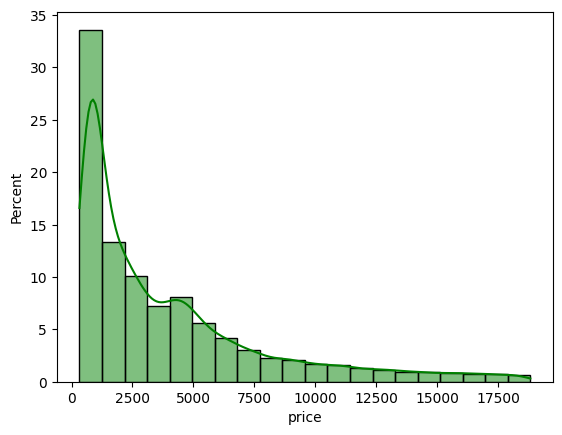

In [105]:
sns.histplot(df["price"], bins=20, stat="percent", kde=True, color="green");

#### 2.1.2. Variables numéricas

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'carat'}>,
        <Axes: title={'center': 'depth'}>],
       [<Axes: title={'center': 'table'}>, <Axes: title={'center': 'x'}>,
        <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >, <Axes: >]], dtype=object)

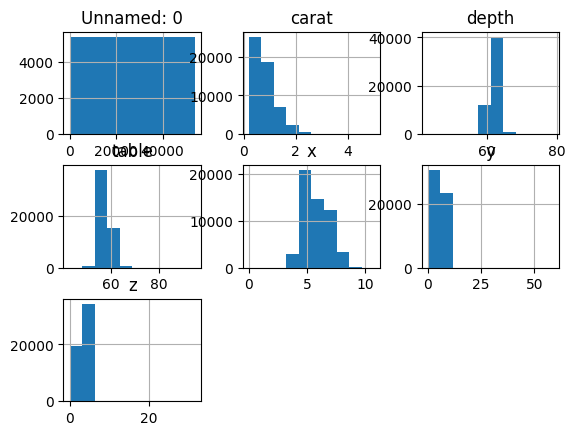

In [106]:
df.drop("price", axis=1).hist()

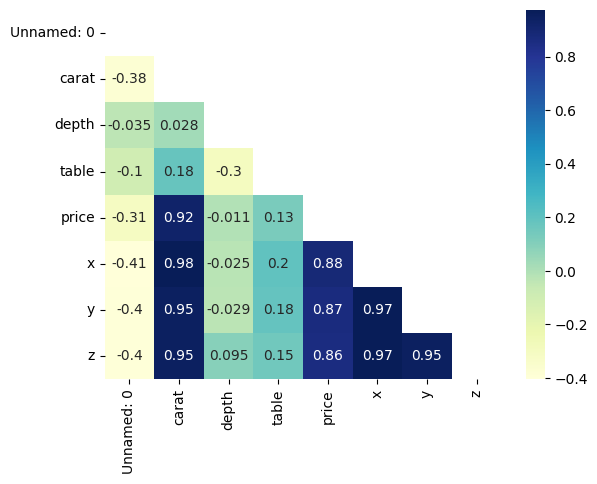

In [107]:
mask = np.triu(np.ones_like(df.select_dtypes(include=np.number).corr(), dtype = np.bool))
sns.heatmap(df.select_dtypes(include=np.number).corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

#### 2.1.3. Variables categóricas

In [108]:
df.describe(include="object")

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


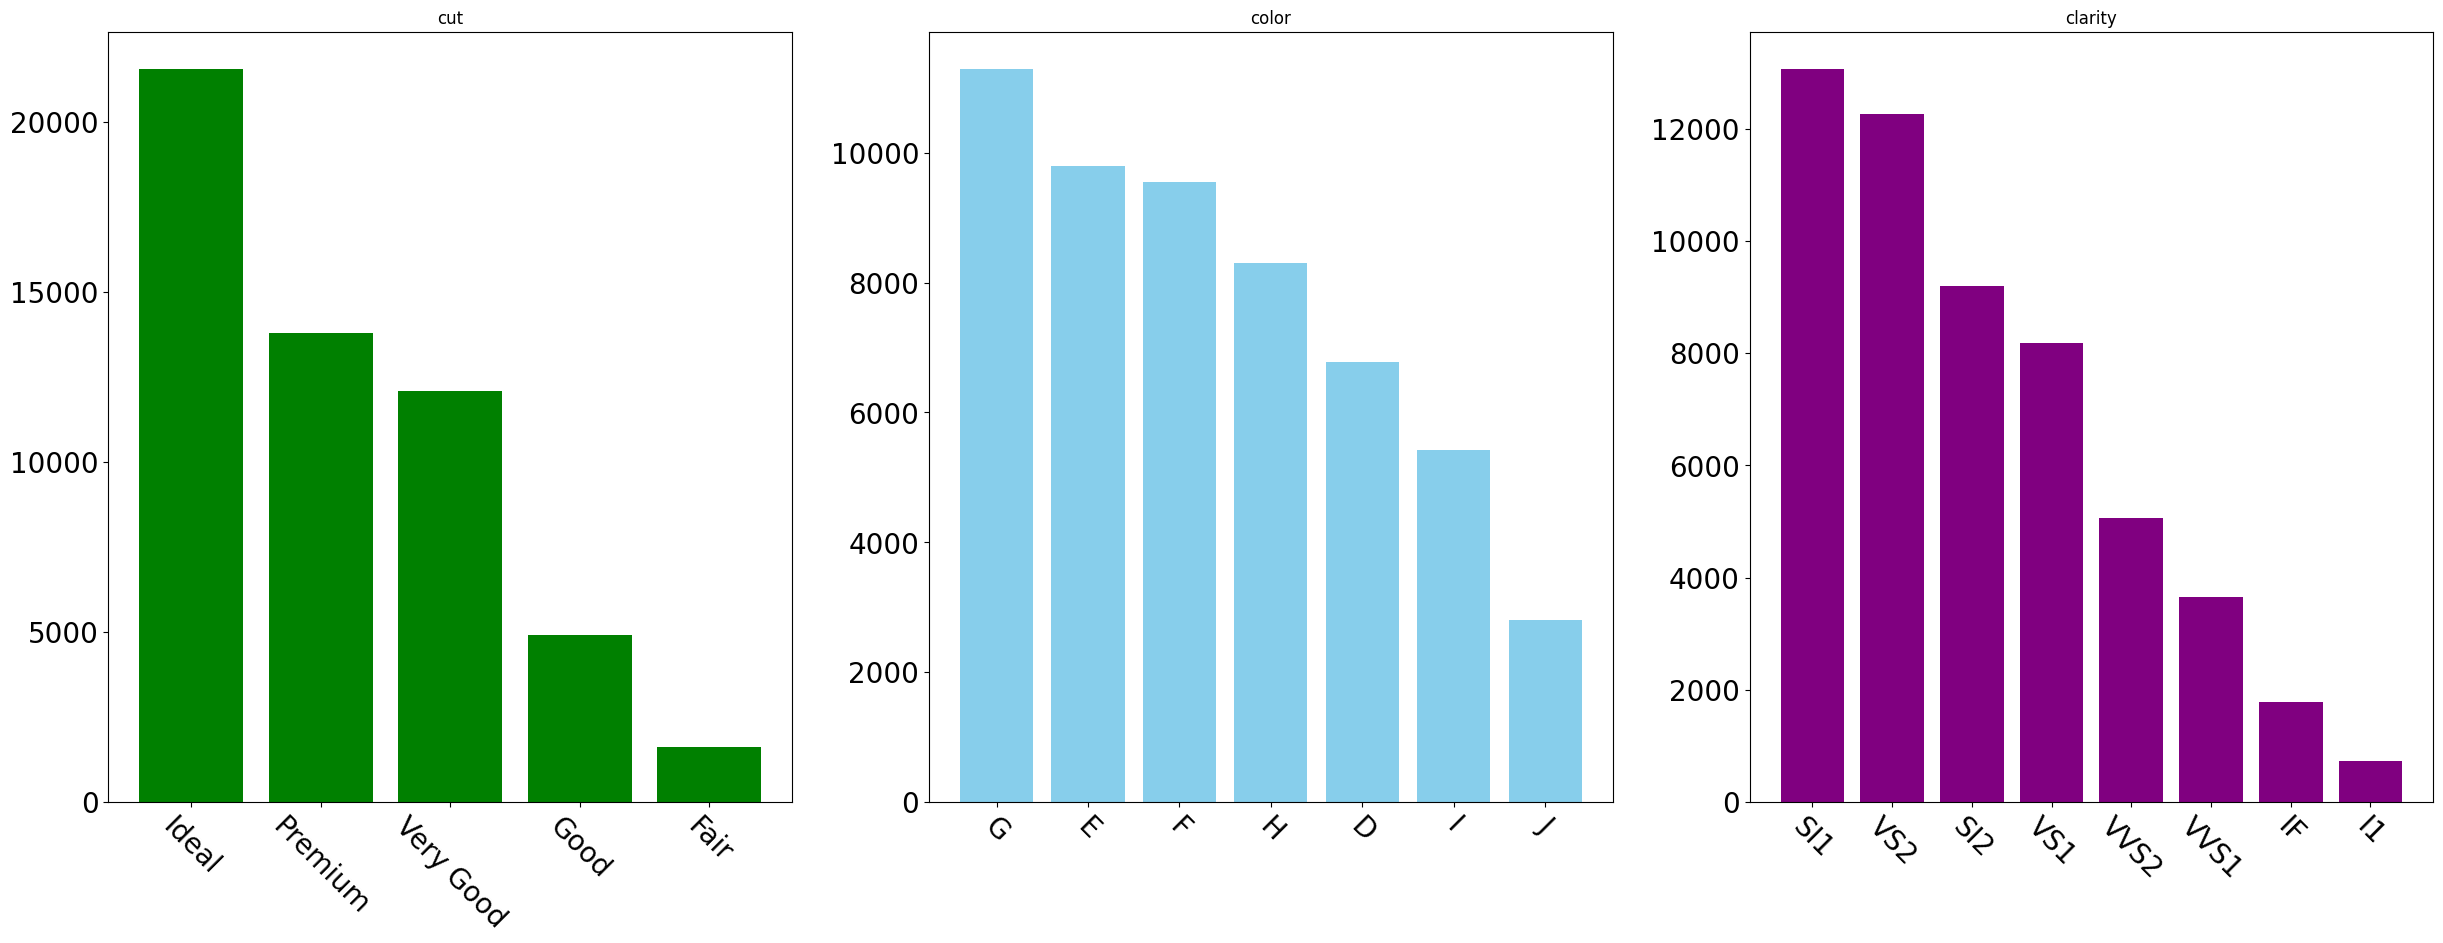

In [109]:
# Mostramos la distribución de las varaibles categóricas

sp.visual_categ(df.select_dtypes(include="object"))

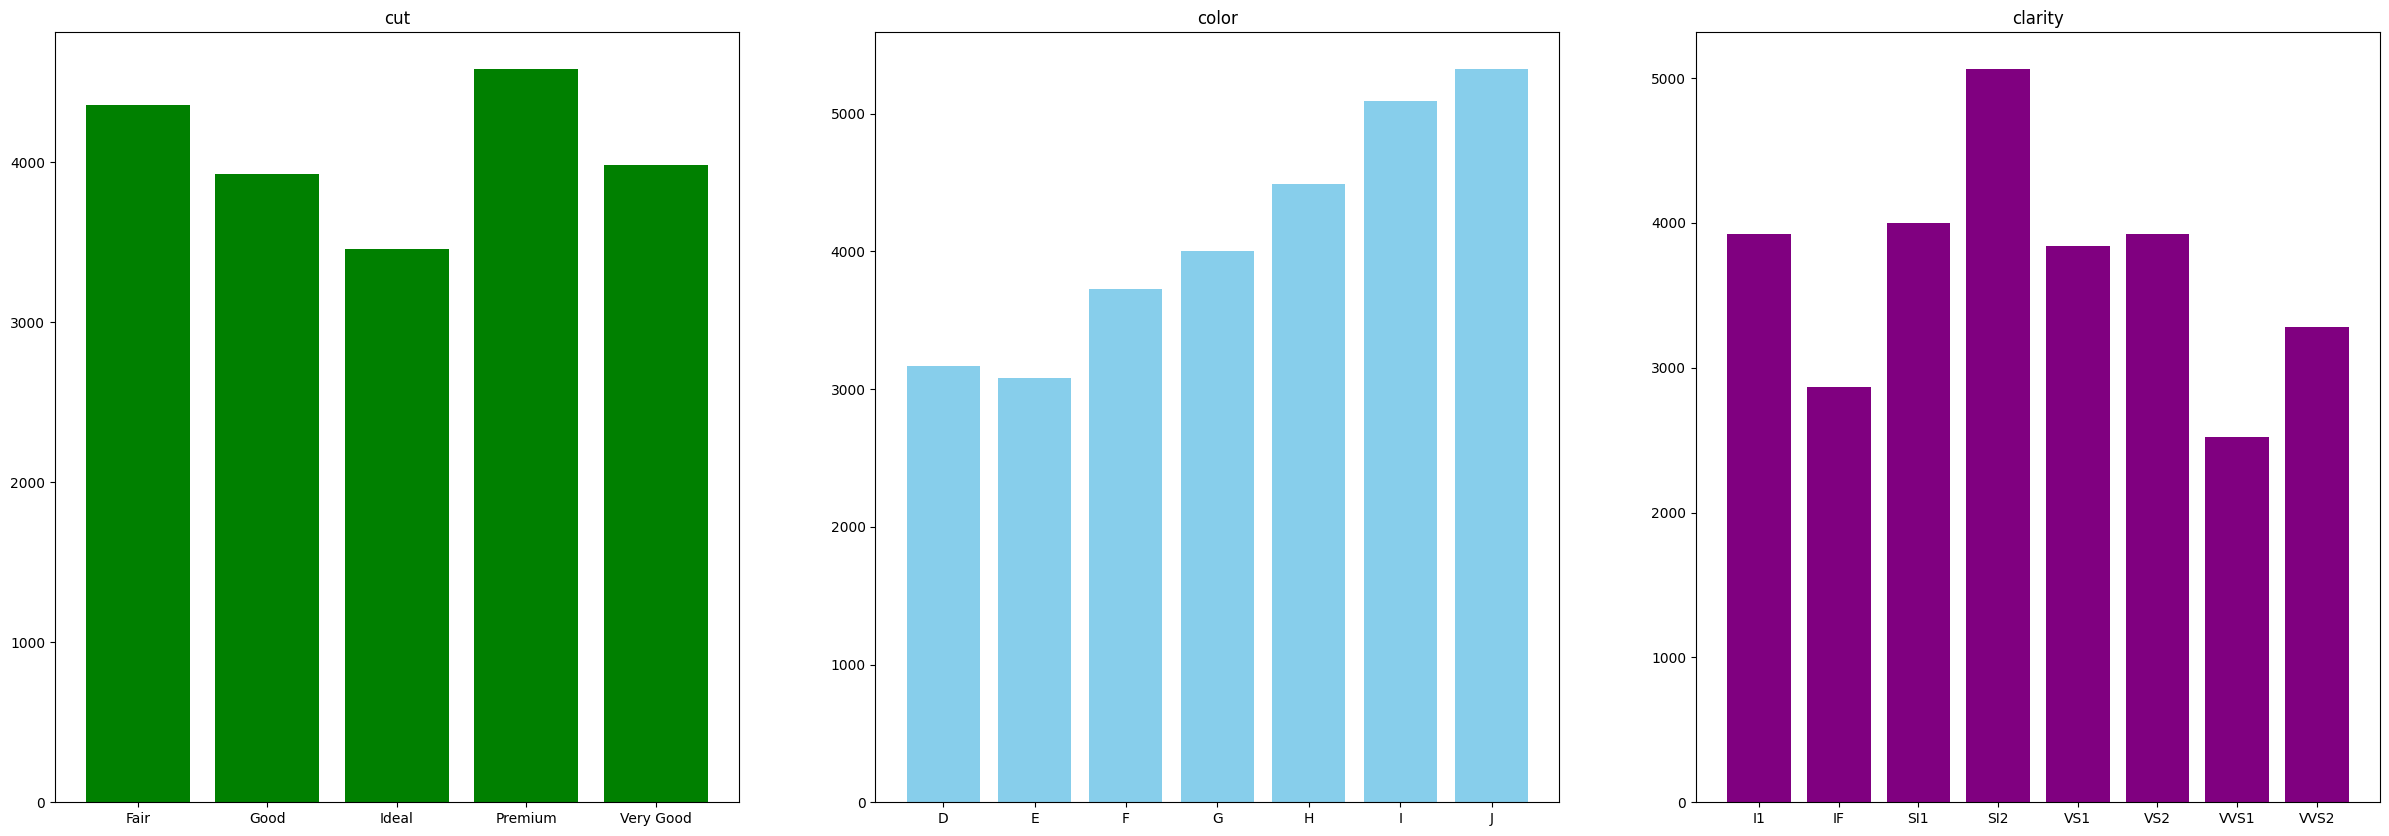

In [110]:
# Mostramos el promedio de precio para cada una de las variables de cada característica de entrada.

sp.mean_price_categ(df)

### 2.2. Preprocesado

In [111]:
# Eliminamos columna de índices

df = df.drop("Unnamed: 0", axis = 1)

In [112]:
# Eliminamos las características x, y, z por la alta correlación con el precio y carat.

df_reduced = df.drop(["x","y","z"], axis=1)

## 3. División del conjunto de datos

In [113]:
train_set, val_set, test_set = sp.train_val_test_split(df_reduced)
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 32364
Longitud del Validation Set: 10788
Longitud del Test Set: 10788


In [ ]:
X_train, y_train = sp.remove_labels(train_set, "price")
X_val, y_val = sp.remove_labels(val_set, "price")
X_test, y_test = sp.remove_labels(test_set, "price")

## 4. Preparación del conjunto de datos

In [ ]:
num_attribs = list(X_train.select_dtypes(exclude=['object']))
cat_attribs = list(X_train.select_dtypes(include=['object']))

In [116]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rbst_scaler", RobustScaler())
])

In [117]:
cat_pipeline = Pipeline([("oh", OneHotEncoder())])

In [118]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [ ]:
X_train_prep = full_pipeline.fit_transform(X_train)

In [130]:
X_train_prep = pd.DataFrame.sparse.from_spmatrix(X_train_prep, columns=list(pd.get_dummies(X_train).columns))

## 5. Entrenamiento del algoritmo

In [133]:
lin_reg = LinearRegression()

In [134]:
lin_reg.fit(X_train_prep, y_train)

LinearRegression()

## 6. Predicciones

In [137]:
X_val_prep = full_pipeline.fit_transform(X_val)
X_val_prep = pd.DataFrame.sparse.from_spmatrix(X_val_prep, columns=list(pd.get_dummies(X_train).columns))

In [142]:
y_test_pred = lin_reg.predict(X_val_prep)

c:\Users\User\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


## 7. Evaluación de los resultados 

In [143]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print("R2:",  metrics.r2_score(y_test, y_test_pred))

Mean Absolute Error: 4095.3333954152777
Mean Squared Error: 30287079.71586519
Root Mean Squared Error: 5503.369850906369
R2: -0.8916397592158787
